# **Machine Learning Applications Final Project Notebook**

Date: May 9, 2023

Authors: Óscar Montoya Amores (100451858), Javier Serrano Sánchez-Ocaña (100451673), Miguel Ángel Ponce Martínez (100451309)

#### **LIBRARIES IMPORT**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy    

## **0. Dataset Loading and DF Preprocessing**

#### **DATASET IMPORT**

Let's load the dataset obtained from Kaggle (https://www.kaggle.com/datasets/elizzyliu/song-lyrics) and obtain the main insights from this data:

In [6]:
df = pd.read_csv('all_lyrics.csv')

display(df)

,song,artist,type,lyrics
0,Stairway to Heaven,Led Zeppelin,rock,Stairway to Heaven Lyrics[Intro]\n\n[Verse 1]\...
1,Hey Jude,Beatles,rock,Hey Jude Lyrics[Verse 1: Paul McCartney]\nHey ...
2,All Along the Watchtower,"Hendrix, Jimi",rock,"Ii. Tambourine Lyrics[Chorus, sung]\nHey, Pip,..."
3,Satisfaction,Rolling Stones,rock,"Sin título I Lyrics[Letra de ""Sin título I""]\n..."
4,Like A Rolling Stone,"Dylan, Bob",rock,Like a Rolling Stone Lyrics[Verse 1]\nOnce upo...
...,...,...,...,...
3995,Motown 25,Elzhi,rap & hip hop,Motown 25 Lyrics[Verse 1: eLZhi]\nI end career...
3996,How Ya Like Me Now,Kool Moe Dee,rap & hip hop,"How Ya Like Me Now Lyrics""All aboard for the n..."
3997,Coastin’,Zion I feat. K.Flay,rap & hip hop,Coastin’ LyricsWhen life brings trouble\nYou c...
3998,Head Banger,EPMD,rap & hip hop,Headbanger Lyrics[Redman]\nNegroes!!!!!!!!\n\n...


In [7]:
df.describe()

,song,artist,type,lyrics
count,4000,4000,4000,3896
unique,3881,1583,4,3761
top,Summertime,Beatles,rock,"Summer Country Songs LyricsA\nAaron Lewis – ""E..."
freq,5,51,1000,10


This dataset is composed by the 1000 most famous songs from every musical genre(``type Variable``) and our goal is find some relation among songs lyrics and its genre. 

Firstly, null values seems to appear in the lyrics row because as we can see 104 songs ``lyrics`` are not counted properly. So first thing wee need to do is remove null values.

Moreover, the unique row bothers us too. It is expected that ``type`` and ``artist`` have several instances repeated (Artist could have many famous songs and obviously given 4 genres it will be repeated). Furthermore, even two different artists could present two different songs with the same name (``song``). However, it is really strange that two songs represent the same lyrics. Here we could have be talking about plagiarism, corrupted data or simply describe() function is not working as expected with long string stucture, so before starting to apply some Machine Learnings Applicatios we have seen in class we need to fix this trouble.

In [8]:
null = df['lyrics'].isna().values

print(f'There are exactly {sum(null)} null values in the lyrics variable which corresponds to the {sum(null)/len(null)*100:.3f}% of the data set')


There are exactly 104 null values in the lyrics variable which corresponds to the 2.600% of the data set


We think this percentege is assumible of being removed from the dataset but before doing so let's see the proportion of songs genre which receives null lyrics. 

<Axes: >

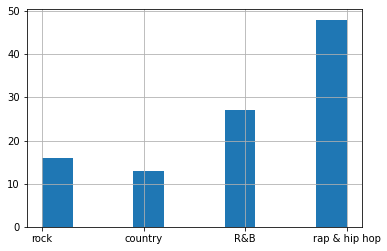

In [9]:
df_null = df[null]
df_null['type'].hist()

Most of the null lyrics are from ``rap & hip hop`` but nothing alarming. We can assume to remove this instances, update the dataframe and repeat a similar process to find out repeted lyrics. 

In [10]:
df = df.dropna(subset=['lyrics', 'type'])

In [11]:
print(df.duplicated().values)

[False False False ... False False False]


There are exactly 14 repeated values in the lyrics variable which corresponds to the 0.359% of the data set


<Axes: >

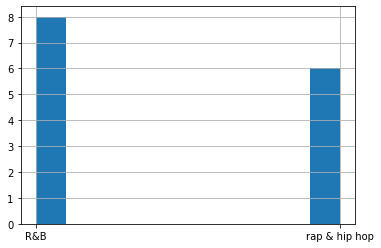

In [12]:
repeated = df[df.duplicated()]
print(f'There are exactly {len(repeated)} repeated values in the lyrics variable which corresponds to the {len(repeated)/len(df)*100:.3f}% of the data set')
repeated['type'].hist()

Again, the ammount of repeated values are not very important but this time is focused on only two genres. However, we will remove it because it is not adding any information and let's repeat the describe() process to finally start to focus on the Machine Learning Apps.

In [13]:
df = df.drop_duplicates(subset=['lyrics'], keep='first').reset_index(drop=True)
df.describe()

,song,artist,type,lyrics
count,3761,3761,3761,3761
unique,3668,1476,4,3761
top,Angel,Beatles,rock,Stairway to Heaven Lyrics[Intro]\n\n[Verse 1]\...
freq,5,48,972,1


Good news regarding the ``lyrics`` variable, is time to begin working with spacy and more NLP libaries we have seen during classes.

## **1. Text Preprocessing and vectorization**

### **1.1 NLP Pipeline**

Before the implementation of the Pipeline let's print some ``lyrics`` instances in order to visualize which kind of none useful set of characters has been introduced

In [14]:
instances = [l for l in df['lyrics'].values[:2]]

for si,s in enumerate(instances):
    print(f'SONG {si + 1}')
    print(str([s])+'\n')

SONG 1
["Stairway to Heaven Lyrics[Intro]\n\n[Verse 1]\nThere's a lady who's sure all that glitters is gold\nAnd she's buying a stairway to Heaven\nWhen she gets there she knows, if the stores are all closed\nWith a word she can get what she came for\nOoh, ooh, and she's buying a stairway to Heaven\nThere's a sign on the wall, but she wants to be sure\n'Cause you know sometimes words have two meanings\nIn a tree by the brook, there's a songbird who sings\nSometimes all of our thoughts are misgiven\n\n[Chorus]\nOoh, it  makes me wonder\nOoh, makes me wonder\n[Verse 2]\nThere's a feeling I get when I look to the West\nAnd my spirit is crying for leaving\nIn my thoughts I have seen rings of smoke through the trees\nAnd the voices of those who stand looking\n\n[Chorus]\nOoh, it makes me wonder\nOoh, really makes me wonder\n\n[Verse 3]\nAnd it's whispered that soon if we all call the tune\nThen the piper will lead us to reason\nAnd a new day will dawn for those who stand long\nAnd the fores

From these two songs we can clearly see that there are a lot of characters which is not necessary at all. Firstly it seems that at the beguining of every song, the title of the song it is included, an iformation wich is stored in other variable and we do not need. Also at the end of the song a sequence of numbers and 'Embed' word is appearing. Furthermore, every information inside '[]' is not corresponding to the lyrics itself. Finally, '/n' wich corresponds to line skip must be removed.

Regarding expresions like 'na', 'yeah', 'hey'... could be interpreted as some kind of stopword which maybe is not a word which express to much but especially in this second song for example it seems to be half of the song. So deppending on troubles we could face, we will change the decision of keeping this strings. However, contractions must be treated as a 'formal' word in orther to obtain the same meaning for every word. This can be counter benefit especially in ``rap & hip hop`` genre which most of the words uses contraction to fit with the rithm of the song. But at the end we are triying to find the meaning of the words in the song and each word must be represented in the same manner in every one.  

Creating a function to address all this problems would be the best manner to properly display the lyrics:

In [15]:
#Maximum length of any song's Title
lengthTitle = df['song'].apply(lambda x: len(x.split(' '))).values
maxLen = np.max(lengthTitle) + 5 #This 5 is just a margin just in case

In [16]:
import re
import contractions
import unicodedata

def correctLyrics(row, maxLen):
    text = row['lyrics']
    #1. Remove '\n' and Unicode Escape Sequence ('\u2005f)
    text =  re.sub(r'\n', ' ', text)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    #2. Remove '[]'
    text = re.sub(r'\[.*?\]', ' ', text)
    #3. Remove initial title + 'Lyrics' Keyword
    titleWords = text.split(' ')[:maxLen] #Save time and avoid errors
    restWords = text.split(' ')[maxLen:]
    titleWords = re.sub(r'.*?Lyrics', '', ' '.join(titleWords))
    text = titleWords + ' ' + ' '.join(restWords)
    #4. Remove 'Embed' at the end word of the song
    text = re.sub(r'\d+Embed|Embed', '', text)
    #5.Avoid more than 1 Espaces
    text = re.sub(r'\s+', ' ', text)
    #6. Remove contractions
    text = contractions.fix(text)
    return text

df['correctLyrics'] = df.apply(lambda x: correctLyrics(x,maxLen), axis=1)

display(df)

,song,artist,type,lyrics,correctLyrics
0,Stairway to Heaven,Led Zeppelin,rock,Stairway to Heaven Lyrics[Intro]\n\n[Verse 1]\...,There is a lady who is sure all that glitters...
1,Hey Jude,Beatles,rock,Hey Jude Lyrics[Verse 1: Paul McCartney]\nHey ...,"Hey Jude, do not make it bad Take a sad song ..."
2,All Along the Watchtower,"Hendrix, Jimi",rock,"Ii. Tambourine Lyrics[Chorus, sung]\nHey, Pip,...","Hey, Pip, play your tambourine Make the sailo..."
3,Satisfaction,Rolling Stones,rock,"Sin título I Lyrics[Letra de ""Sin título I""]\n...",Hay tres ninas jipis en la habitacion Una se ...
4,Like A Rolling Stone,"Dylan, Bob",rock,Like a Rolling Stone Lyrics[Verse 1]\nOnce upo...,Once upon a time you dressed so fine Threw th...
...,...,...,...,...,...
3756,Motown 25,Elzhi,rap & hip hop,Motown 25 Lyrics[Verse 1: eLZhi]\nI end career...,"I end careers, years, pierce ears fierce with..."
3757,How Ya Like Me Now,Kool Moe Dee,rap & hip hop,"How Ya Like Me Now Lyrics""All aboard for the n...","""All aboard for the night train"" I throw my ta..."
3758,Coastin’,Zion I feat. K.Flay,rap & hip hop,Coastin’ LyricsWhen life brings trouble\nYou c...,When life brings trouble You can fight or run ...
3759,Head Banger,EPMD,rap & hip hop,Headbanger Lyrics[Redman]\nNegroes!!!!!!!!\n\n...,"Negroes!!!!!!!! The head banger, WHAT? The he..."


After all these modifications let's see if the previous songs lyrics has an uniform structure: 

In [17]:
instances = [l for l in df['correctLyrics'].values[:2]]

for si,s in enumerate(instances):
    print(f'SONG {si + 1}')
    print(str([s])+'\n')

SONG 1
[" There is a lady who is sure all that glitters is gold And she is buying a stairway to Heaven When she gets there she knows, if the stores are all closed With a word she can get what she came for Ooh, ooh, and she is buying a stairway to Heaven There is a sign on the wall, but she wants to be sure Because you know sometimes words have two meanings In a tree by the brook, there is a songbird who sings Sometimes all of our thoughts are misgiven Ooh, it makes me wonder Ooh, makes me wonder There is a feeling I get when I look to the West And my spirit is crying for leaving In my thoughts I have seen rings of smoke through the trees And the voices of those who stand looking Ooh, it makes me wonder Ooh, really makes me wonder And it is whispered that soon if we all call the tune Then the piper will lead us to reason And a new day will dawn for those who stand long And the forests will echo with laughter Oh-oh-oh-oh-woahhh If there is a bustle in your hedgerow, do not be alarmed now

Now, these lyrics seems to be readable, escape sequences and Unicode elements has been removed, both title at the begining of the word and Embed at the has been also adressed. Finally, contractions has been recover onto its original verb. So far, so good.

However, something we need to know previously working with songs lyrics is that our dataset is about the 1000 most heard songs for every genre but this does not implies that all our songs are in the same language! Therefore, it would be useful to determine which language predominates for each song and in the case of minoritary languages, remove that instance because otherwise it would be impossible to asign a topic for these kind of sentences. Therefore, it is the moment to visualize which language priorises in this dataset and which other languages could surprise us.

In [18]:
from spacy.language import Language
from spacy_langdetect import LanguageDetector

# Add LanguageDetector and assign it a string name
@Language.factory("language_detector")
def create_language_detector(nlp, name):
    return LanguageDetector(language_detection_function=None)

mult_nlp = spacy.load('xx_sent_ud_sm')

mult_nlp.add_pipe('language_detector', last=True)

mult_doc = mult_nlp(df['correctLyrics'].values[0])
def getLanguage(row):
    mult_doc = mult_nlp(row['correctLyrics'])
    return mult_doc._.language['language']

df['language'] = df.apply(getLanguage, axis = 1)

Surprisingly it only tooks one minute!. When we iniciate the process we were expecting 30 mins at list. This is not bad at all, now we can see which languages predominates in our dataset and this could be good information for a better interpretation of the number of topics we may need to select. Let's plot a histogram to visualize how this ``language`` variable is distributed.

<Axes: >

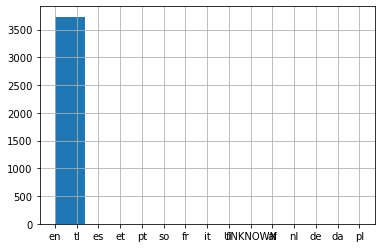

In [19]:
df['language'].hist()

Wow! Almost every song is in english. So, obviously this will be the main language in the corpus. However, let's put the spotlight in those minoritary languages, it does not seem that they include sufficient enough docs to perform a correct. Thus, let's focus now in this languages songs:

Tne number of non-english songs is 32 which correspond to 0.851% of the dataset


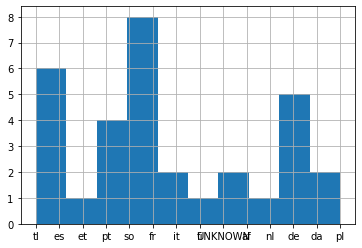

In [20]:
dfNoteng = df.loc[df['language'] != 'en']
dfNoteng['language'].hist()
print(f'Tne number of non-english songs is {dfNoteng.shape[0]} which correspond to {dfNoteng.shape[0]/df.shape[0]*100:.3f}% of the dataset')

It is less than a 1% of the total songs and the most repeated language is 'tagalog' which is a philipine language and are 6 instances of this language. Therefore it is assumible the loss of these instances. Therefore, after this deletion it is our time to apply our spicy Pipeline after the creation of the corpus.

In [21]:
df = df.loc[df['language'] == 'en'].reset_index(drop=True)

corpus = [elem for elem in df['correctLyrics']]

with open('corpus.txt', 'w+') as c:
    c.write(str(corpus))

``corpus`` variable is composed by a long list including every song on it. We have done is in this way because we think Python lists for this kind of task would be faster than using Pandas Dataframes. From this we will create a Pipeline simiarily as we did in classes notebook and use further machine learning algorithm as final work statement requests.

Once the ``corpus`` has been created, it is very easy to apply a Pipeline:

In [22]:
from num2words import num2words
from tqdm import tqdm
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stopwords_en = stopwords.words('english')
wnl = WordNetLemmatizer()

#IMPORT CORPUS
with open('corpus.txt', 'r') as c:
    corpus = eval(c.read())
##############

valid_POS = set(['VERB', 'NOUN', 'ADJ', 'PROPN', 'NUM'])

def convertNum2words(token):
    try:
        return num2words(token)
    except:
        return token

def corpusPreprocessing(song):
    #1. Tokenization
    doc = wordpunct_tokenize(song)
    #2. Filtering by Alphanumeric and Lower the Text
    lowerToken = [token.lower() for token in doc if token.isalnum()]
    tokenList = [convertNum2words(token) for token in lowerToken]
    #3. Lemmatization of the data
    lemmaList = [wnl.lemmatize(el) for el in tokenList]
    #4. Cleanning StopWords
    finalCorpus = [lemma for lemma in lemmaList if lemma not in stopwords_en]
    return finalCorpus

corpus = [corpusPreprocessing(s) for s in tqdm(corpus)]

100%|██████████| 3729/3729 [00:34<00:00, 108.65it/s]


In [23]:
#SAVE CORPUS
with open('corpus.txt', 'w+') as c:
    c.write(str(corpus))
##############

It is surprisingly fast compared to the Pipeline provided by SpaCy. In only took 33 seconds which is 10 times less than the previous Pipeline we constructed but we decided to rewrite it because of the lack of performance and .lower() was not available. Anyway, we decided to store this new corpus inside a txt file such as a 'checkpoint' to save time as much as possible.

### **1.2 Text Vectorization**

Now it is the moment of use N-Grams from ``gensim`` library in order to group in the same token those words that has a tendency of appear together:

In [24]:
#IMPORT CORPUS
with open('corpus.txt', 'r') as c:
    corpus = eval(c.read())
##############

from gensim.models.phrases import Phrases

phrase_model = Phrases(corpus, min_count=2, threshold=20)

corpus = [el for el in tqdm(phrase_model[corpus])]

100%|██████████| 3729/3729 [00:02<00:00, 1519.17it/s]


Finally, in order to find a BoW and TF-IDF representation from our corpus, it is necessary to create previously a Gensim Dictionary where the songs will be stored. Once it is created, we can't include more instances, therefore this step is only made when the corpus has been finished.

In [25]:
from gensim.corpora import Dictionary

# Create dictionary of tokens
D = Dictionary(corpus)

print('Our dictionary contains', len(D), 'terms')

Our dictionary contains 78935 terms


Wow! more than 70000 terms in our diccionary. Compared to what we saw from IMBD dataset, this ones contains more items. However, this is not definitive, probably there are several terms that appears barely compared to from what we see in the IMBD which maybe follows a similar structure since a review could be good, bad but nothing else. Let's filter our Diccionary and we will see which are the real tokens that we will need to analyse:

In [26]:
D.filter_extremes(no_below=3,no_above=.80)

print('Our dictionary contains', len(D), 'terms')

Our dictionary contains 24464 terms


Now it makes sense, it decreased drastically and now it seems to be a good bunch of woords to work with. Now it is the moment to introduce clasical representations which using Gensim is quite easy:

In [27]:
from gensim.models import TfidfModel

bow_songs = [D.doc2bow(doc) for doc in corpus]
tfidf = TfidfModel(bow_songs)
tfidf_songs = tfidf[bow_songs]

print('Hey Ya! - Outkast:')
print(corpus[2534])
print(bow_songs[2534])
print(tfidf_songs[2534])

Hey Ya! - Outkast:
['pack', 'grip', 'takin', 'trip', 'seat', 'got', 'dancin', 'foot', 'leave', 'worry_behind', 'rain_shine', 'mind', 'ridin_groove', 'line', 'tonight', 'get', 'train', 'know', 'glad_came', 'hit', 'track', 'party', 'hard', 'back', 'leave', 'worry_behind', 'leave', 'worry_behind', 'rain_shine', 'mind', 'ridin_groove', 'line', 'tonight', 'check', 'wheel_turnin', 'know', 'stop', 'got', 'boiler', 'burnin', 'keepin_hot', 'grab', 'friend', 'get', 'train', 'comin', 'climb', 'board', 'leave', 'leave', 'worry_behind', 'leave', 'worry_behind', 'rain_shine', 'mind', 'ridin_groove', 'line', 'tonight', 'leave', 'worry_behind', 'leave', 'worry_behind', 'rain_shine', 'mind', 'ridin_groove', 'line', 'tonight', 'check', 'wheel_turnin', 'know', 'stop', 'got', 'boiler', 'burnin', 'yeah', 'keepin_hot', 'grab', 'friend', 'get', 'train', 'comin', 'climb', 'board', 'leave', 'leave', 'worry_behind', 'leave', 'worry_behind', 'rain_shine', 'mind', 'ridin_groove', 'line', 'tonight', 'ride', 'rain_

Therefore, this is our first figures obteinment from the words appearing in the lyrics song. Nevertheless, this is not enough to predict properly which genre our song has. This representation just considers the frequency of appearing but not the relation among words. For example, in this song ``Hey Ya! - Outkast``, word 'hey' which is some kind of musical onomatopoeia is repeated several times during the song, and its score is 0.53 in the TF-IDF representation which is really high despite it does not meaning anything the word by itself. But is not that bad, for example 'na' expresion could directly being related to pop song, we do not know how the classification model will behave. Furthermore, these kind of representations will be very useful for the developement of more complex models thus it is essential to save them in a variable for future usages.

Without any more introduction, it is the moment to start developing further text-figure extraction models in order to obtain better insights from our data:

#### **1.2.1 Word2Vec Representation**

In [28]:
#TODO
#WORD2VEC 

#### **1.2.2 FastText Representation**

FastText is another approach toward word representation for future classification tasks we are going to develop during this notebook. Furthermore, we had an idea due to our Neural Network Course which was to implement an MLP NN in the classification task.

Moreover, this algorithim is idoneal for short docs as songs lyrics are and in classes notebook we saw a Pipeline which returns the average of the embeddings of the words which will be really useful for the Neural Network and its linear layers.

In order to maximize the performance and make our algorithm as robust as possible we will directly load any pre-trained model and adjust it using our corpus. Therefore, first of all we need to load the model which can help us as much as possible.

In [29]:
import compress_fasttext

fastTextPre = compress_fasttext.models.CompressedFastTextKeyedVectors.load(
    'ft_cc.en.300_freqprune_100K_20K_pq_100.bin'
)

We decided to dowload a pre-trained model from Github (https://github.com/avidale/compress-fasttext/releases/tag/gensim-4-draft) which is based on cc.en.300.bin which was the model we used in class but updated up to Gensim >= 4.0.0  also trained over a Facebook Dataset.

Let's show how this model has been trained by showing some similar words to the first word of the 5th first song of our dataset, just to check that clearly it makes sense to use it. Furthermore, even if the word does not appear in our FastText Dictionary, it will construct an embedding anyway therefore is very useful as we said before in order to make it as robust as possible to non-appearing words.

In [30]:
for w in corpus[:5]:
    print(f'Word similar to {w[0]}:')
    print(str(fastTextPre.most_similar(w[0]))+'\n')

Word similar to lady:
[('woman', 0.7058992023242795), ('gentleman', 0.6620858776059471), ('girl', 0.6586058469783472), ('ladies', 0.6508614740853009), ('man', 0.5864333917215517), ('maid', 0.5358822322333194), ('gal', 0.5181655356649635), ('hostess', 0.5132772625084043), ('guy', 0.5079906678342049), ('husband', 0.4979106432241984)]

Word similar to hey:
[('yeah', 0.7789288401059054), ('Hey', 0.6943406755833088), ('yes', 0.6628033304769274), ('dunno', 0.6605168916282228), ('Anyway', 0.6503646563032917), ('thats', 0.6460367334322566), ('anyways', 0.6437630045067626), ('Yeah', 0.6402671861130218), ('yea', 0.6398807760628002), ('maybe', 0.638750632189878)]

Word similar to upon:
[('Upon', 0.5571007189608188), ('on', 0.5232045155852151), ('based', 0.4705611885703212), ('solely', 0.4348302498291361), ('the', 0.42164649077587435), ('placed', 0.42072702630631886), ('brought', 0.3952660894980005), ('reliance', 0.394296303722936), ('dependent', 0.3939951307776036), ('rests', 0.3935409751083754)]

It looks quite good, for example an onomatopoeia such as 'hey' is related to others like 'yeah'. The main problem I see from this relations is that some of them are just the same word but starting in capital letters. That is not a big problem and we always can create our own model based on our corpus and compare its efficiency with respect to this one which clearly seems to have been worked properly.

Final step is the creation of our dataset from our corpus through the obtention of word embeddings mean of every song and from this we will be able to develop any classification task in the Second Part of this notebook.

In [31]:
from compress_fasttext.feature_extraction import FastTextTransformer

corpusVec = FastTextTransformer(model=fastTextPre).transform(corpus)

print(f'Corpus Matrix Dimension is: {corpusVec.shape}')

Corpus Matrix Dimension is: (3729, 300)


Using FastTextTransformer we are able to obtain the embbedings of every song lyrics in our dataset. As we can see the number of songs clearly coincide with the number of total songs our dataset has and 300 columns represents the vector size our pre-trained model has. This is sufficient enough to develop our Machine Learning Task but we will save it here and we will continue with this in the Second Part.

### **1.3 Topic Modeling**

In [64]:
#TODO

#TOPIC SELECTION
#SEMANTIC SIMILARITY-LDA

## **2.Machine Learning Model**

### **2.1 Classification Task**

#### **2.1.1 Machine Learning Approach**

In [65]:
#TODO
#MACHINE LEARNING IN CLASS

#### **2.1.2 Deep Learning Approach**

During our course on Neural Networks(https://aplicaciones.uc3m.es/cpa/generaFicha?&est=350&plan=392&asig=16506&idioma=2) we have learned how to develop many types of NN such as MLPs, CNNs, RNNs etc. For this simple task of classification, directly comes to our mind a MLP which is one of the simplest ones and using the mean of the embbedings our text vectorizaation models has provided us we can direclty train this kind of NN and compare its result with respect to the previous obtained by different machine learning algorithms we have provided.

First of all is neccesary to load Pytorch which will be the Deep Learning library we have been using during the course:

In [41]:
import torch
from torch import nn
from torch import optim

Next step is the obtention of a training and testing set and because we are talking about Deep learning, in order to check overfitting during the training: 

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Y = df['type'].values

# Discretize 'string' variables using sklearn
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)

x_train, x_test, y_train, y_test = train_test_split(corpusVec, Y, test_size=0.3, random_state=33)

#Validation set is obtained from the train set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=33)

In [203]:
class MLP_2layer(nn.Module):
    def __init__(self,input_size,hidden1,hidden2,output_size, drop): 
        super().__init__()
        
        self.output1 = nn.Linear(input_size,hidden1)
        self.output2 = nn.Linear(hidden1,hidden2)
        self.output3 = nn.Linear(hidden2,output_size)
        
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)     
        self.dropout = nn.Dropout(drop)                                                        
        
    def forward(self, x):
        # First Layer
        x = self.dropout(self.relu(self.output1(x)))
        # Second Layer
        x = self.dropout(self.relu(self.output2(x)))
        # Output 
        out = self.logsoftmax(self.output3(x))
        return out
    
class MLP_2layer_train(MLP_2layer):
    
    def __init__(self,input_size,hidden1,hidden2, output_size, drop=0.0,lr=0.0005, batch_size=50):
        
        super().__init__(input_size,hidden1,hidden2,output_size,drop)  
        
        self.lr = lr # Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr) # Optimizer
        self.criterion = nn.NLLLoss()               
        
        self.batch_size = batch_size
        self.loss_during_training = [] 
        self.valid_loss_during_training = [] 
           
    def score(self,x_test,Y):
        accuracy = 0.0
        
        with torch.no_grad(): 
            logprobs = self.forward(torch.Tensor(x_test)).detach().numpy()
            if(len(Y)>0):
                accuracy = np.sum(np.argmax(logprobs,1)==Y)/np.shape(Y)[0]
            
        return logprobs,accuracy
            
    def fit(self,x_train,x_val,Y,Yval,epochs=100):
        x_train = torch.Tensor(x_train)
        x_val = torch.Tensor(x_val)
        labels = torch.Tensor(Y).type(torch.LongTensor) # Training labels
        labelsval = torch.Tensor(Yval).type(torch.LongTensor) # Validation labels
        
        self.epochs=epochs
        
        self.num_train = len(x_train) # Number of training points
        self.num_batchs = np.floor(self.num_train/self.batch_size) # Number of training batches
        self.num_val = len(x_val) # Number of validation points
        self.num_batchs_val = np.floor(self.num_val/self.batch_size) # Numero of validating batches
        
        
        for e in range(int(self.epochs)): 
            self.train() # Activate dropout
            running_loss = 0.
            
            # Random data permutation
            idx = np.random.permutation(self.num_train)
            
            for i in range(int(self.num_batchs)):
                self.optim.zero_grad() 
                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]
                # We compute the classifier output for every data
                out = self.forward(x_train[idx_batch])
                # Cost function and gradient descent step
                loss = self.criterion(out,labels[idx_batch])
                running_loss += loss.item()
                loss.backward()
                # Gradient clipping
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                # SGD steps
                self.optim.step()
            
            # print(running_loss)
            self.loss_during_training.append(running_loss/self.num_batchs)
            
            # We repeat for validation
            with torch.no_grad():    
                # set model to evaluation mode
                self.eval()
                running_loss = 0.
                
                idx = np.random.permutation(self.num_val)
                
                for i in range(int(self.num_batchs_val)):
                    idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size] 
                    out = self.forward(x_val[idx_batch])
                    loss = self.criterion(out,labelsval[idx_batch])
                    running_loss += loss.item() 
                    
                self.valid_loss_during_training.append(running_loss/self.num_batchs_val)    
                    

class MLP_3layer(nn.Module):
    def __init__(self,input_size,hidden1,hidden2,hidden3,output_size,p): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(input_size,hidden1)
        self.output2 = nn.Linear(hidden1,hidden2)
        self.output3 = nn.Linear(hidden2,hidden3)
        self.output4 = nn.Linear(hidden3,output_size)
        
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)     
        self.dropout = nn.Dropout(p)                                                        
        
    def forward(self, x):
        # First Layer
        x = self.dropout(self.relu(self.output1(x)))
        # Second Layer
        x = self.dropout(self.relu(self.output2(x)))
        # Third Layer
        x = self.dropout(self.relu(self.output3(x)))
        # Output 
        out = self.logsoftmax(self.output4(x))
        return out

The datails of above NN will be especially especified at the report but averall is a MLP with 2 linear layers and Negative Log-Likelihood as loss function in order to check overfitting over the validation set.

Now is the moment of defining the MLP, training it and plot how much the loss varies depending on which is the set:

In [204]:
my_MLP1 = MLP_2layer_train(input_size=300, hidden1 = 32, hidden2 = 16, 
                        output_size = 4, drop=0.33)


my_MLP1.fit(x_train,x_val,y_train,y_val,epochs=50)

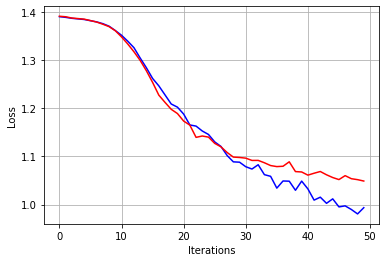

In [205]:
plt.plot(my_MLP1.loss_during_training,label='Training Cross Entropy Loss', color = 'blue')
plt.plot(my_MLP1.valid_loss_during_training,label='validation Cross Entropy Loss', color = 'red')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()

From above plot we can see that after 50-60 iterations our model became to overfit. Let's visualize the accuracy of the model:

In [206]:
logprobs,acc = my_MLP1.score(x_test, y_test)

probs = np.exp(logprobs)  

print(f"The test accuracy is {acc}")

The test accuracy is 0.5218945487042002


In [217]:
print(probs)

[[0.03138079 0.02201927 0.91960275 0.02699715]
 [0.44919252 0.22249137 0.01209561 0.31622046]
 [0.48529086 0.19133629 0.01813954 0.3052333 ]
 ...
 [0.4348792  0.24464771 0.0027639  0.3177091 ]
 [0.41060963 0.25875726 0.00101456 0.32961857]
 [0.4137459  0.2436534  0.02148508 0.32111558]]


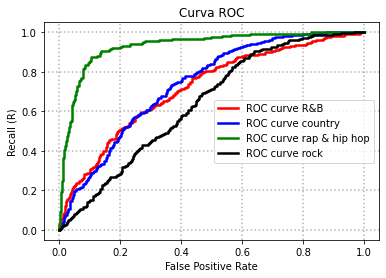

AUC ROC for MLP1 is 0.759


In [238]:
from sklearn import metrics
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

Y_decoded = encoder.inverse_transform([0,1,2,3]) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for MLP1 is {area_roc:.4f}")

That's not enough, our MLP with high droput did not figure out. From this base let's develop another MLP but now adding another layer and reducing the dropout during the process:

In [207]:
class MLP_3layer(nn.Module):
    def __init__(self,input_size,hidden1,hidden2,hidden3,output_size,p): 
        super().__init__()
        
        self.output1 = nn.Linear(input_size,hidden1)
        self.output2 = nn.Linear(hidden1,hidden2)
        self.output3 = nn.Linear(hidden2,hidden3)
        self.output4 = nn.Linear(hidden3,output_size)
        
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)     
        self.dropout = nn.Dropout(p)                                                        
        
    def forward(self, x):
        # First Layer
        x = self.dropout(self.relu(self.output1(x)))
        # Second Layer
        x = self.dropout(self.relu(self.output2(x)))
        # Third Layer
        x = self.dropout(self.relu(self.output3(x)))
        # Output 
        out = self.logsoftmax(self.output4(x))
        return out

class MLP_3layer_train(MLP_3layer):
    
    def __init__(self,input_size,hidden1,hidden2,hidden3, output_size, drop=0.0,lr=0.0005, batch_size=50):
        
        super().__init__(input_size,hidden1,hidden2,hidden3,output_size,drop)  
        
        self.lr = lr # Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr) # Optimizer
        self.criterion = nn.NLLLoss()               
        
        self.batch_size = batch_size
        self.loss_during_training = [] 
        self.valid_loss_during_training = [] 
           
    def score(self,x_test,Y):
        accuracy = 0.0
        
        with torch.no_grad(): 
            logprobs = self.forward(torch.Tensor(x_test)).detach().numpy()
            if(len(Y)>0):
                accuracy = np.sum(np.argmax(logprobs,1)==Y)/np.shape(Y)[0]
            
        return logprobs,accuracy
            
    def fit(self,x_train,x_val,Y,Yval,epochs=100):
        x_train = torch.Tensor(x_train)
        x_val = torch.Tensor(x_val)
        labels = torch.Tensor(Y).type(torch.LongTensor) # Training labels
        labelsval = torch.Tensor(Yval).type(torch.LongTensor) # Validation labels
        
        self.epochs=epochs
        
        self.num_train = len(x_train) # Number of training points
        self.num_batchs = np.floor(self.num_train/self.batch_size) # Number of training batches
        self.num_val = len(x_val) # Number of validation points
        self.num_batchs_val = np.floor(self.num_val/self.batch_size) # Numero of validating batches
        
        
        for e in range(int(self.epochs)): 
            self.train() # Activate dropout
            running_loss = 0.
            
            # Random data permutation
            idx = np.random.permutation(self.num_train)
            
            for i in range(int(self.num_batchs)):
                self.optim.zero_grad() 
                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]
                # We compute the classifier output for every data
                out = self.forward(x_train[idx_batch])
                # Cost function and gradient descent step
                loss = self.criterion(out,labels[idx_batch])
                running_loss += loss.item()
                loss.backward()
                # Gradient clipping
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                # SGD steps
                self.optim.step()
            
            # print(running_loss)
            self.loss_during_training.append(running_loss/self.num_batchs)
            
            # We repeat for validation
            with torch.no_grad():    
                # set model to evaluation mode
                self.eval()
                running_loss = 0.
                
                idx = np.random.permutation(self.num_val)
                
                for i in range(int(self.num_batchs_val)):
                    idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size] 
                    out = self.forward(x_val[idx_batch])
                    loss = self.criterion(out,labelsval[idx_batch])
                    running_loss += loss.item() 
                    
                self.valid_loss_during_training.append(running_loss/self.num_batchs_val) 

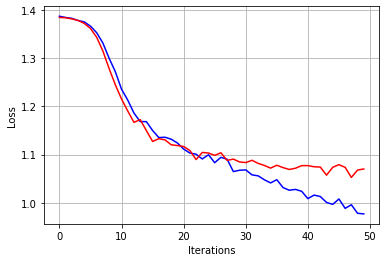

In [214]:
my_MLP2 = MLP_3layer_train(input_size=300, hidden1 = 32, hidden2 = 16, hidden3=8,
                        output_size = 4, drop=0.1)


my_MLP2.fit(x_train,x_val,y_train,y_val,epochs=50)

plt.plot(my_MLP2.loss_during_training,label='Training Cross Entropy Loss', color = 'blue')
plt.plot(my_MLP2.valid_loss_during_training,label='validation Cross Entropy Loss', color = 'red')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()

In [215]:
logprobs,acc = my_MLP2.score(x_test, y_test)

probs = np.exp(logprobs)  

print(f"The test accuracy is {acc}")

The test accuracy is 0.5084897229669347


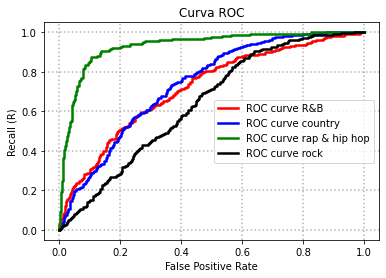

AUC ROC for MLP2 is 0.7585


In [239]:
from sklearn import metrics
fpr0, recall0, thresholds0 = metrics.roc_curve(y_test, probs[:,0], pos_label=0) 
fpr1, recall1, thresholds1 = metrics.roc_curve(y_test, probs[:,1], pos_label=1) 
fpr2, recall2, thresholds2 = metrics.roc_curve(y_test, probs[:,2], pos_label=2) 
fpr3, recall3, thresholds3 = metrics.roc_curve(y_test, probs[:,3], pos_label=3) 

fig,ax = plt.subplots()
plt.plot(fpr0, recall0,lw=2.5,label=f'ROC curve {Y_decoded[0]}', color = 'red')
plt.plot(fpr1, recall1,lw=2.5,label=f'ROC curve {Y_decoded[1]}', color = 'blue')
plt.plot(fpr2, recall2,lw=2.5,label=f'ROC curve {Y_decoded[2]}', color = 'green')
plt.plot(fpr3, recall3,lw=2.5,label=f'ROC curve {Y_decoded[3]}', color = 'black')
plt.legend(loc=7)
plt.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, probs,  multi_class='ovr')

print(f"AUC ROC for MLP2 is {area_roc:.4f}")

It is even worse! Compared to other NN we have developed in the other course at least these MLPs are more robust to overfit. Furthermore clearly the implementation of a new layer to reduce the dropout does not worked unfortunatelly. 

Our expectations over these MLPs were higher than what we get returned because in the course of NN we have also created one of this over a NLP dataset and its accuracy were much higher. Obiously the dataset always is very important in the final result, but I do not know, I was expecting more. 

### **2.2 Clustering Task**

In [67]:
#TODO
#UNSUPERVISED LEARNING REGARDING CLUSTERING